# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [ ]:
import torch.nn.functional as F
dropout_value = 0.025
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # 28x28x1 => 26x26x8

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # 26x26x8 => 24x24x16

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # 24x24x10
        self.pool1 = nn.MaxPool2d(2, 2) # 24x24x10 => 12x12x10

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # 12x12x10 => 10x10x16
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # 10x10x16 =>8x8x16
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # 8x8x16 => 6x6x10
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # 6x6x10 => 6x6x10

        self.pool2 = nn.MaxPool2d(2, 2) # 6x6x10 => 3x3x10


        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1

        self.fc = nn.Linear(10 ,10 )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool2(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1) # Explicitly flatten to (batch_size, number_of_features)
        x = self.fc(x)


        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
print("Please ensure you have run the cell with the updated Net class definition before running this cell.")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
Please ensure you have run the cell with the updated Net class definition before running this cell.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR
num_epochs = 15
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.75,  # Peak LR (0.75)
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,  # 30% warmup
    anneal_strategy='cos',
    div_factor=7.5,  # Initial LR = 0.75 / 7.5 = 0.1
    final_div_factor=7.5,  # Final LR = 0.75 / 7.5 = 0.1
    cycle_momentum=False  # Disable momentum cycling for Adagrad
)


EPOCHS = num_epochs
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Loss=0.11257778853178024 Batch_id=468 Accuracy=94.00: 100%|██████████| 469/469 [00:24<00:00, 19.37it/s]



Test set: Average loss: 0.0536, Accuracy: 9830/10000 (98.30%)

EPOCH: 1


Loss=0.07065742462873459 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:17<00:00, 27.46it/s]



Test set: Average loss: 0.0539, Accuracy: 9832/10000 (98.32%)

EPOCH: 2


Loss=0.03327016159892082 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]



Test set: Average loss: 0.0423, Accuracy: 9860/10000 (98.60%)

EPOCH: 3


Loss=0.078425832092762 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]



Test set: Average loss: 0.0273, Accuracy: 9912/10000 (99.12%)

EPOCH: 4


Loss=0.016846932470798492 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:17<00:00, 27.37it/s]



Test set: Average loss: 0.0285, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.012577938847243786 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]



Test set: Average loss: 0.0226, Accuracy: 9938/10000 (99.38%)

EPOCH: 6


Loss=0.029798345640301704 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 27.11it/s]



Test set: Average loss: 0.0273, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.016402876004576683 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:18<00:00, 25.79it/s]



Test set: Average loss: 0.0240, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Loss=0.001689160824753344 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:17<00:00, 26.96it/s]



Test set: Average loss: 0.0211, Accuracy: 9930/10000 (99.30%)

EPOCH: 9


Loss=0.026836350560188293 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:18<00:00, 25.79it/s]



Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.011960809119045734 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]



Test set: Average loss: 0.0210, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.02944987080991268 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:18<00:00, 25.68it/s]



Test set: Average loss: 0.0205, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.10526969283819199 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 27.22it/s]



Test set: Average loss: 0.0264, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.012089435942471027 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:18<00:00, 25.79it/s]



Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.0072224629111588 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]



Test set: Average loss: 0.0220, Accuracy: 9942/10000 (99.42%)



# Let's Train and test our model

This time let's add a scheduler for out LR.

Text(0.5, 1.0, 'Test Accuracy')

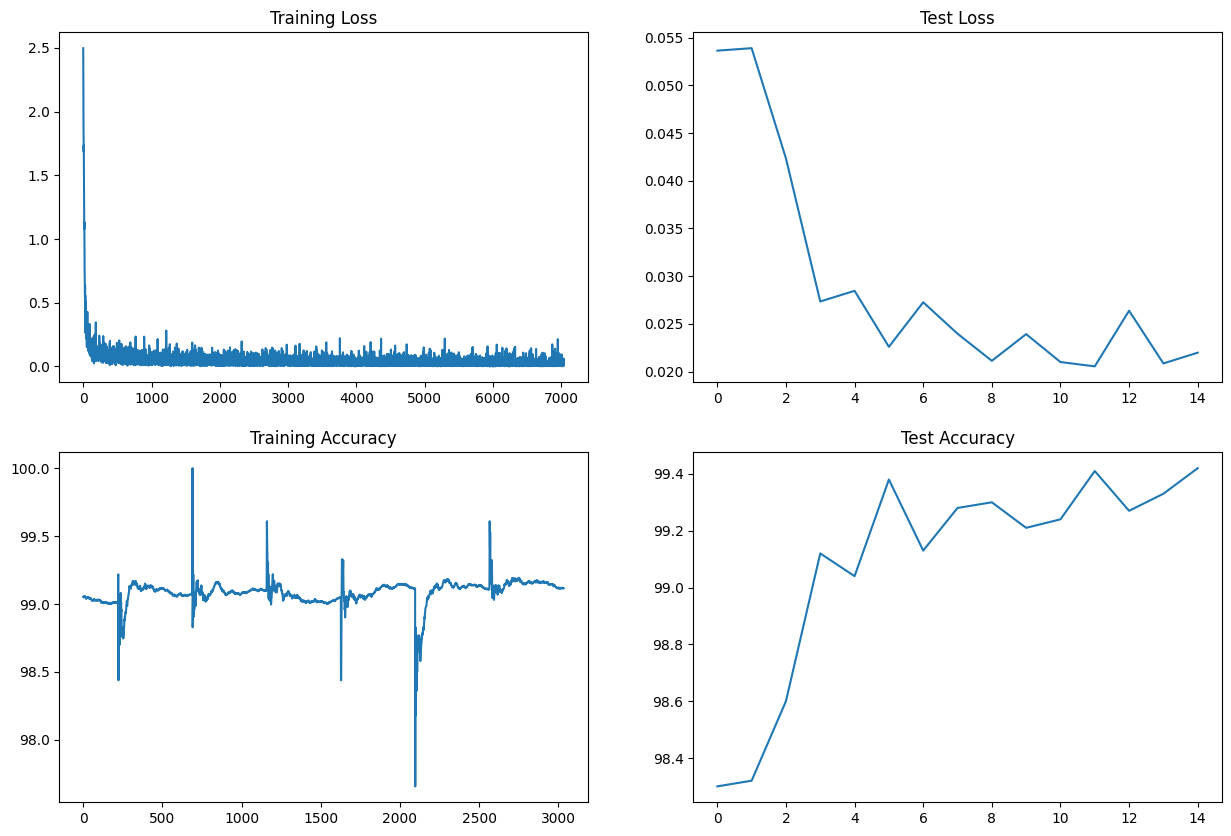

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")